<a href="https://colab.research.google.com/github/Rajsoni03/Sentiment-Analysis-of-Amazon-Product-Reviews/blob/main/Marge_Data_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Librtaries

In [2]:
import tensorflow as tf

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import json
import gzip
from urllib.request import urlopen

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download and Import the Amazon Review Data (2018) Dataset


Dataset Link - https://nijianmo.github.io/amazon/index.html

In [3]:
# download data zip file
# matadata
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

# review data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Clothing_Shoes_and_Jewelry_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Home_and_Kitchen_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Kindle_Store_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Sports_and_Outdoors_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Toys_and_Games_5.json.gz

--2021-11-23 06:33:42--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  50.3MB/s    in 3.4s    

2021-11-23 06:33:46 (48.1 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]

--2021-11-23 06:33:46--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53965563 (51M) [application/octet-stream]
Saving to: ‘Arts_Crafts_and_Sewin

In [4]:
data_set_name = {
    1 : 'Cell_Phones_and_Accessories',
    2 : 'Arts_Crafts_and_Sewing',
    3 : 'Clothing_Shoes_and_Jewelry',
    4 : 'Books',
    5 : 'Electronics',
    6 : 'Kindle_Store',
    7 : 'Sports_and_Outdoors',
    8 : 'Toys_and_Games'
}

In [5]:
def extract_data(data_name):
  ### load the meta data
  data = []
  path = '/content/'+ data_name + '_5.json.gz'
  count = 1
  with gzip.open(path) as f:
    for l in f:
      data.append(json.loads(l.strip()))
      if count >= 100000:
        break
      count += 1
      
  # total length of list, this number equals total number of products
  print(len(data), ':', data_name)

  # first row of the list
  # print(data[0])

  return data

In [6]:
data = {}
for data_name in data_set_name.values():
  data[data_name] = extract_data(data_name)

100000 : Cell_Phones_and_Accessories
100000 : Arts_Crafts_and_Sewing
100000 : Clothing_Shoes_and_Jewelry
100000 : Books
100000 : Electronics
100000 : Kindle_Store
100000 : Sports_and_Outdoors
100000 : Toys_and_Games


# Data Analysis and Preprocessing

In [7]:
def process_data(data_array, data_name):
  # convert list into pandas dataframe
  print('######[ Processing', data_name, 'Data ]######')

  df = pd.DataFrame.from_dict(data_array)
  df = df[['overall', 'reviewText']]

  print("Unique Rating : ", df['overall'].unique())

  df = df[df['reviewText'].notna()]

  # convert target type from float to int
  df = df.astype({'overall': 'int32'})

  # df['overall'].plot(kind='hist', title='Rating Distribution of {}'.format(data_name))
  # plt.show()

  # handle class imbalance problem
  rus  = RandomUnderSampler(random_state=42)
  df, _ = rus.fit_resample(df, df['overall'])
  df = pd.DataFrame(df, columns=['overall','reviewText'])
  print('Final size of data :', len(df), '\n')

  # convert target type from float to int
  df = df.astype({'overall': 'int32'})

  # df['overall'].plot(kind='hist', title='Target Distribution after undersampling of {}'.format(data_name));
  # plt.show()

  return df

In [8]:
processed_data = {}
for data_name, data_array in data.items():
  processed_data[data_name] = process_data(data_array, data_name)

######[ Processing Cell_Phones_and_Accessories Data ]######
Unique Rating :  [5. 3. 2. 4. 1.]
Final size of data : 30380 

######[ Processing Arts_Crafts_and_Sewing Data ]######
Unique Rating :  [4. 5. 2. 3. 1.]
Final size of data : 12955 

######[ Processing Clothing_Shoes_and_Jewelry Data ]######
Unique Rating :  [5. 4. 2. 3. 1.]
Final size of data : 22750 

######[ Processing Books Data ]######
Unique Rating :  [5. 3. 2. 4. 1.]
Final size of data : 17420 

######[ Processing Electronics Data ]######
Unique Rating :  [5. 3. 4. 2. 1.]
Final size of data : 17525 

######[ Processing Kindle_Store Data ]######
Unique Rating :  [4. 5. 3. 2. 1.]
Final size of data : 18655 

######[ Processing Sports_and_Outdoors Data ]######
Unique Rating :  [5. 1. 4. 3. 2.]
Final size of data : 16610 

######[ Processing Toys_and_Games Data ]######
Unique Rating :  [5. 4. 2. 1. 3.]
Final size of data : 16630 



In [9]:
# Marge the data of all catagories to a single dataframe
final_data = pd.concat(processed_data.values())
final_data.shape

(152925, 2)

In [15]:
# converting rationg to binary labels (1 = Good, 0 = Bad)
y = final_data.iloc[:, 0].values > 2
y = np.array([int(i) for i in y])

In [16]:
# split data into training and validation set in ratio of 9:1
X_train, X_test, Y_train, Y_test = train_test_split(final_data['reviewText'], y, random_state=42, train_size=0.9, stratify=y)

print('No. of samples Training data :', X_train.shape[0])
print('No. of samples Validation data :', X_test.shape[0]) 

No. of samples Training data : 137632
No. of samples Validation data : 15293


In [ ]:
# Get one hot encoding of Y_train
# Y_train = pd.get_dummies(Y_train)
# Y_test = pd.get_dummies(Y_test)

# Y_train.head()

# Tensorflow Word Preprocessing

In [17]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [18]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(X_train[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? save your money and invest in an otterbox this is a poor imitation at a great product the plastic is cheap and the rubber doesn't fit properly
1    Characters you don't care about, exposition in...
1    This is a rugged case, but you will not be abl...
1                        pile of garbage, don't buy it
1    but definitly NOT...  tiny book..  make robot ...
1    From buying this totally waste of technology. ...
1    I am so frustrated with Anita Shreve.  I canno...
1    The only thing nice I can say is it is made of...
1                                           Toxic??!!!
Name: reviewText, dtype: object


In [20]:
padded.shape

(137632, 120)

# TF Model Training

In [21]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(120, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 120)          9720      
                                                                 
 global_average_pooling1d (G  (None, 120)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                3872      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 173,625
Trainable params: 173,625
Non-trainable params: 0
__________________________________________________

In [22]:
num_epochs = 10
history = model.fit(padded, Y_train, epochs=num_epochs, validation_data=(testing_padded, Y_test))

Epoch 1/10
4301/4301 [==============================] - 39s 7ms/step - loss: 0.5674 - accuracy: 0.7013 - val_loss: 0.4786 - val_accuracy: 0.7722
Epoch 2/10
4301/4301 [==============================] - 28s 7ms/step - loss: 0.4481 - accuracy: 0.7909 - val_loss: 0.4474 - val_accuracy: 0.7885
Epoch 3/10
4301/4301 [==============================] - 28s 7ms/step - loss: 0.4218 - accuracy: 0.8042 - val_loss: 0.4344 - val_accuracy: 0.7976
Epoch 4/10
4301/4301 [==============================] - 30s 7ms/step - loss: 0.4076 - accuracy: 0.8128 - val_loss: 0.4290 - val_accuracy: 0.8003
Epoch 5/10
4301/4301 [==============================] - 30s 7ms/step - loss: 0.3979 - accuracy: 0.8191 - val_loss: 0.4281 - val_accuracy: 0.8007
Epoch 6/10
4301/4301 [==============================] - 30s 7ms/step - loss: 0.3907 - accuracy: 0.8238 - val_loss: 0.4243 - val_accuracy: 0.7995
Epoch 7/10
4301/4301 [==============================] - 30s 7ms/step - loss: 0.3847 - accuracy: 0.8266 - val_loss: 0.4237 - val_ac

In [ ]:
num_epochs = 10
history = model.fit(padded, Y_train, epochs=num_epochs, validation_data=(testing_padded, Y_test))

Epoch 1/10
4301/4301 [==============================] - 78s 18ms/step - loss: 0.3577 - accuracy: 0.8378 - val_loss: 0.3584 - val_accuracy: 0.8384
Epoch 2/10
4301/4301 [==============================] - 74s 17ms/step - loss: 0.3567 - accuracy: 0.8380 - val_loss: 0.3573 - val_accuracy: 0.8380
Epoch 3/10
4301/4301 [==============================] - 77s 18ms/step - loss: 0.3558 - accuracy: 0.8381 - val_loss: 0.3567 - val_accuracy: 0.8386
Epoch 4/10
4301/4301 [==============================] - 76s 18ms/step - loss: 0.3545 - accuracy: 0.8385 - val_loss: 0.3566 - val_accuracy: 0.8383
Epoch 5/10
4301/4301 [==============================] - 83s 19ms/step - loss: 0.3538 - accuracy: 0.8387 - val_loss: 0.3558 - val_accuracy: 0.8376
Epoch 6/10
4301/4301 [==============================] - 75s 18ms/step - loss: 0.3528 - accuracy: 0.8391 - val_loss: 0.3572 - val_accuracy: 0.8376
Epoch 7/10
4301/4301 [==============================] - 83s 19ms/step - loss: 0.3520 - accuracy: 0.8390 - val_loss: 0.3538 -

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Amazon Review/model.h5')

# Evaluate Model Performance 

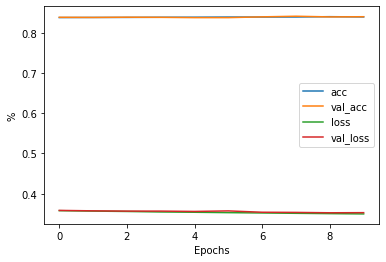

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('%')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'])
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(testing_padded).arg

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

# Test With Custom Input

In [48]:
your_review = "the product is good, i am satisfied with it"

In [49]:
your_padded_review = pad_sequences(tokenizer.texts_to_sequences([your_review]), maxlen=max_length, truncating=trunc_type)
prediction = model.predict(your_padded_review)[0][0]

if prediction > 0.5:
  print('good')
else:
  print('not good')

prediction

good


0.9821914

In [50]:
your_review = "the product is vary bad, do not buy this"

In [51]:
your_padded_review = pad_sequences(tokenizer.texts_to_sequences([your_review]), maxlen=max_length, truncating=trunc_type)
prediction = model.predict(your_padded_review)[0][0]

if prediction > 0.5:
  print('good')
else:
  print('not good')

prediction

not good


0.11449351